## Import required libraries

In [1]:
import os
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D

from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

### Extract File names from Dataset folder

In [2]:
filenames = []
for file in os.listdir('Dataset'):
    filenames.append(os.path.join('Dataset',file))

In [3]:
filenames[0:5]

['Dataset\\10037.jpg',
 'Dataset\\10039.jpg',
 'Dataset\\10054.jpg',
 'Dataset\\10096.jpg',
 'Dataset\\10097.jpg']

In [4]:
len(filenames)

2906

### Importing ResNet50 Model and Cofiguration

In [5]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.trainable = False
model = tf.keras.models.Sequential([
    model, 
    GlobalMaxPooling2D() 
 ])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Extracting Fetaures from Image

In [7]:
img = image.load_img('2828.jpg', target_size=(224,224))
img_array = image.img_to_array(img)   ## Convert this to numpy array
img_expand_dim = np.expand_dims(img_array, axis=0)   ## Convert this 3D array to 4D array as resnet50 model accepts images in batches
img_preprocess = preprocess_input(img_expand_dim)    ## Preprocess the image from RGB to BRG as model accepts this formar
result = model.predict(img_preprocess).flatten()     ## 2048 features extracted from single image
norm_result = result/norm(result)                    ## Normalize/Scale the values between 0 & 1
norm_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


array([0.00473047, 0.00459416, 0.01044738, ..., 0.        , 0.00707158,
       0.00082895], dtype=float32)

In [8]:
## Create a function to extract features for all the images
def extract_features_from_images(image_path, model):
    try:
        img = image.load_img(image_path, target_size=(224,224))
        img_array = image.img_to_array(img)
        img_expand_dim = np.expand_dims(img_array, axis=0)
        img_preprocess = preprocess_input(img_expand_dim)
        result = model.predict(img_preprocess, verbose=0).flatten() 
        
        # Normalize features
        norm_result = result/norm(result) 
        return norm_result
    except UnidentifiedImageError:
        print(f"Could not process image: {image_path}")
        return None

In [9]:
extract_features_from_images(filenames[1], model)

array([0.00206278, 0.0004201 , 0.01140374, ..., 0.01632076, 0.00383485,
       0.01801864], dtype=float32)

### Extract features from all the images in the dataset folder

In [10]:
image_features = []
for file in tqdm(filenames):
    image_features.append(extract_features_from_images(file, model))

100%|██████████| 2906/2906 [19:19<00:00,  2.51it/s]


### Save the image feature vectors and file name

In [11]:
import pickle
pickle.dump(image_features, open('Images_features.pkl','wb'))
pickle.dump(filenames, open('filenames.pkl','wb'))

In [12]:
image_features = pickle.load(open('Images_features.pkl','rb'))
filenames = pickle.load(open('filenames.pkl','rb'))

In [13]:
np.array(image_features).shape

(2906, 2048)

### Building the NearestNeighbors algorithm

In [19]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')

### Fitting the model

In [20]:
neighbors.fit(image_features)

,n_neighbors,6
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'euclidean'
,p,2
,metric_params,None
,n_jobs,None


### Testing with one sample image

In [23]:
input_image = extract_features_from_images('2828.jpg',model)

In [24]:
distance,indices = neighbors.kneighbors([input_image])

In [42]:
indices[0]

array([ 709,  423, 1762,  751, 1479,  608], dtype=int64)

In [28]:
from IPython.display import Image

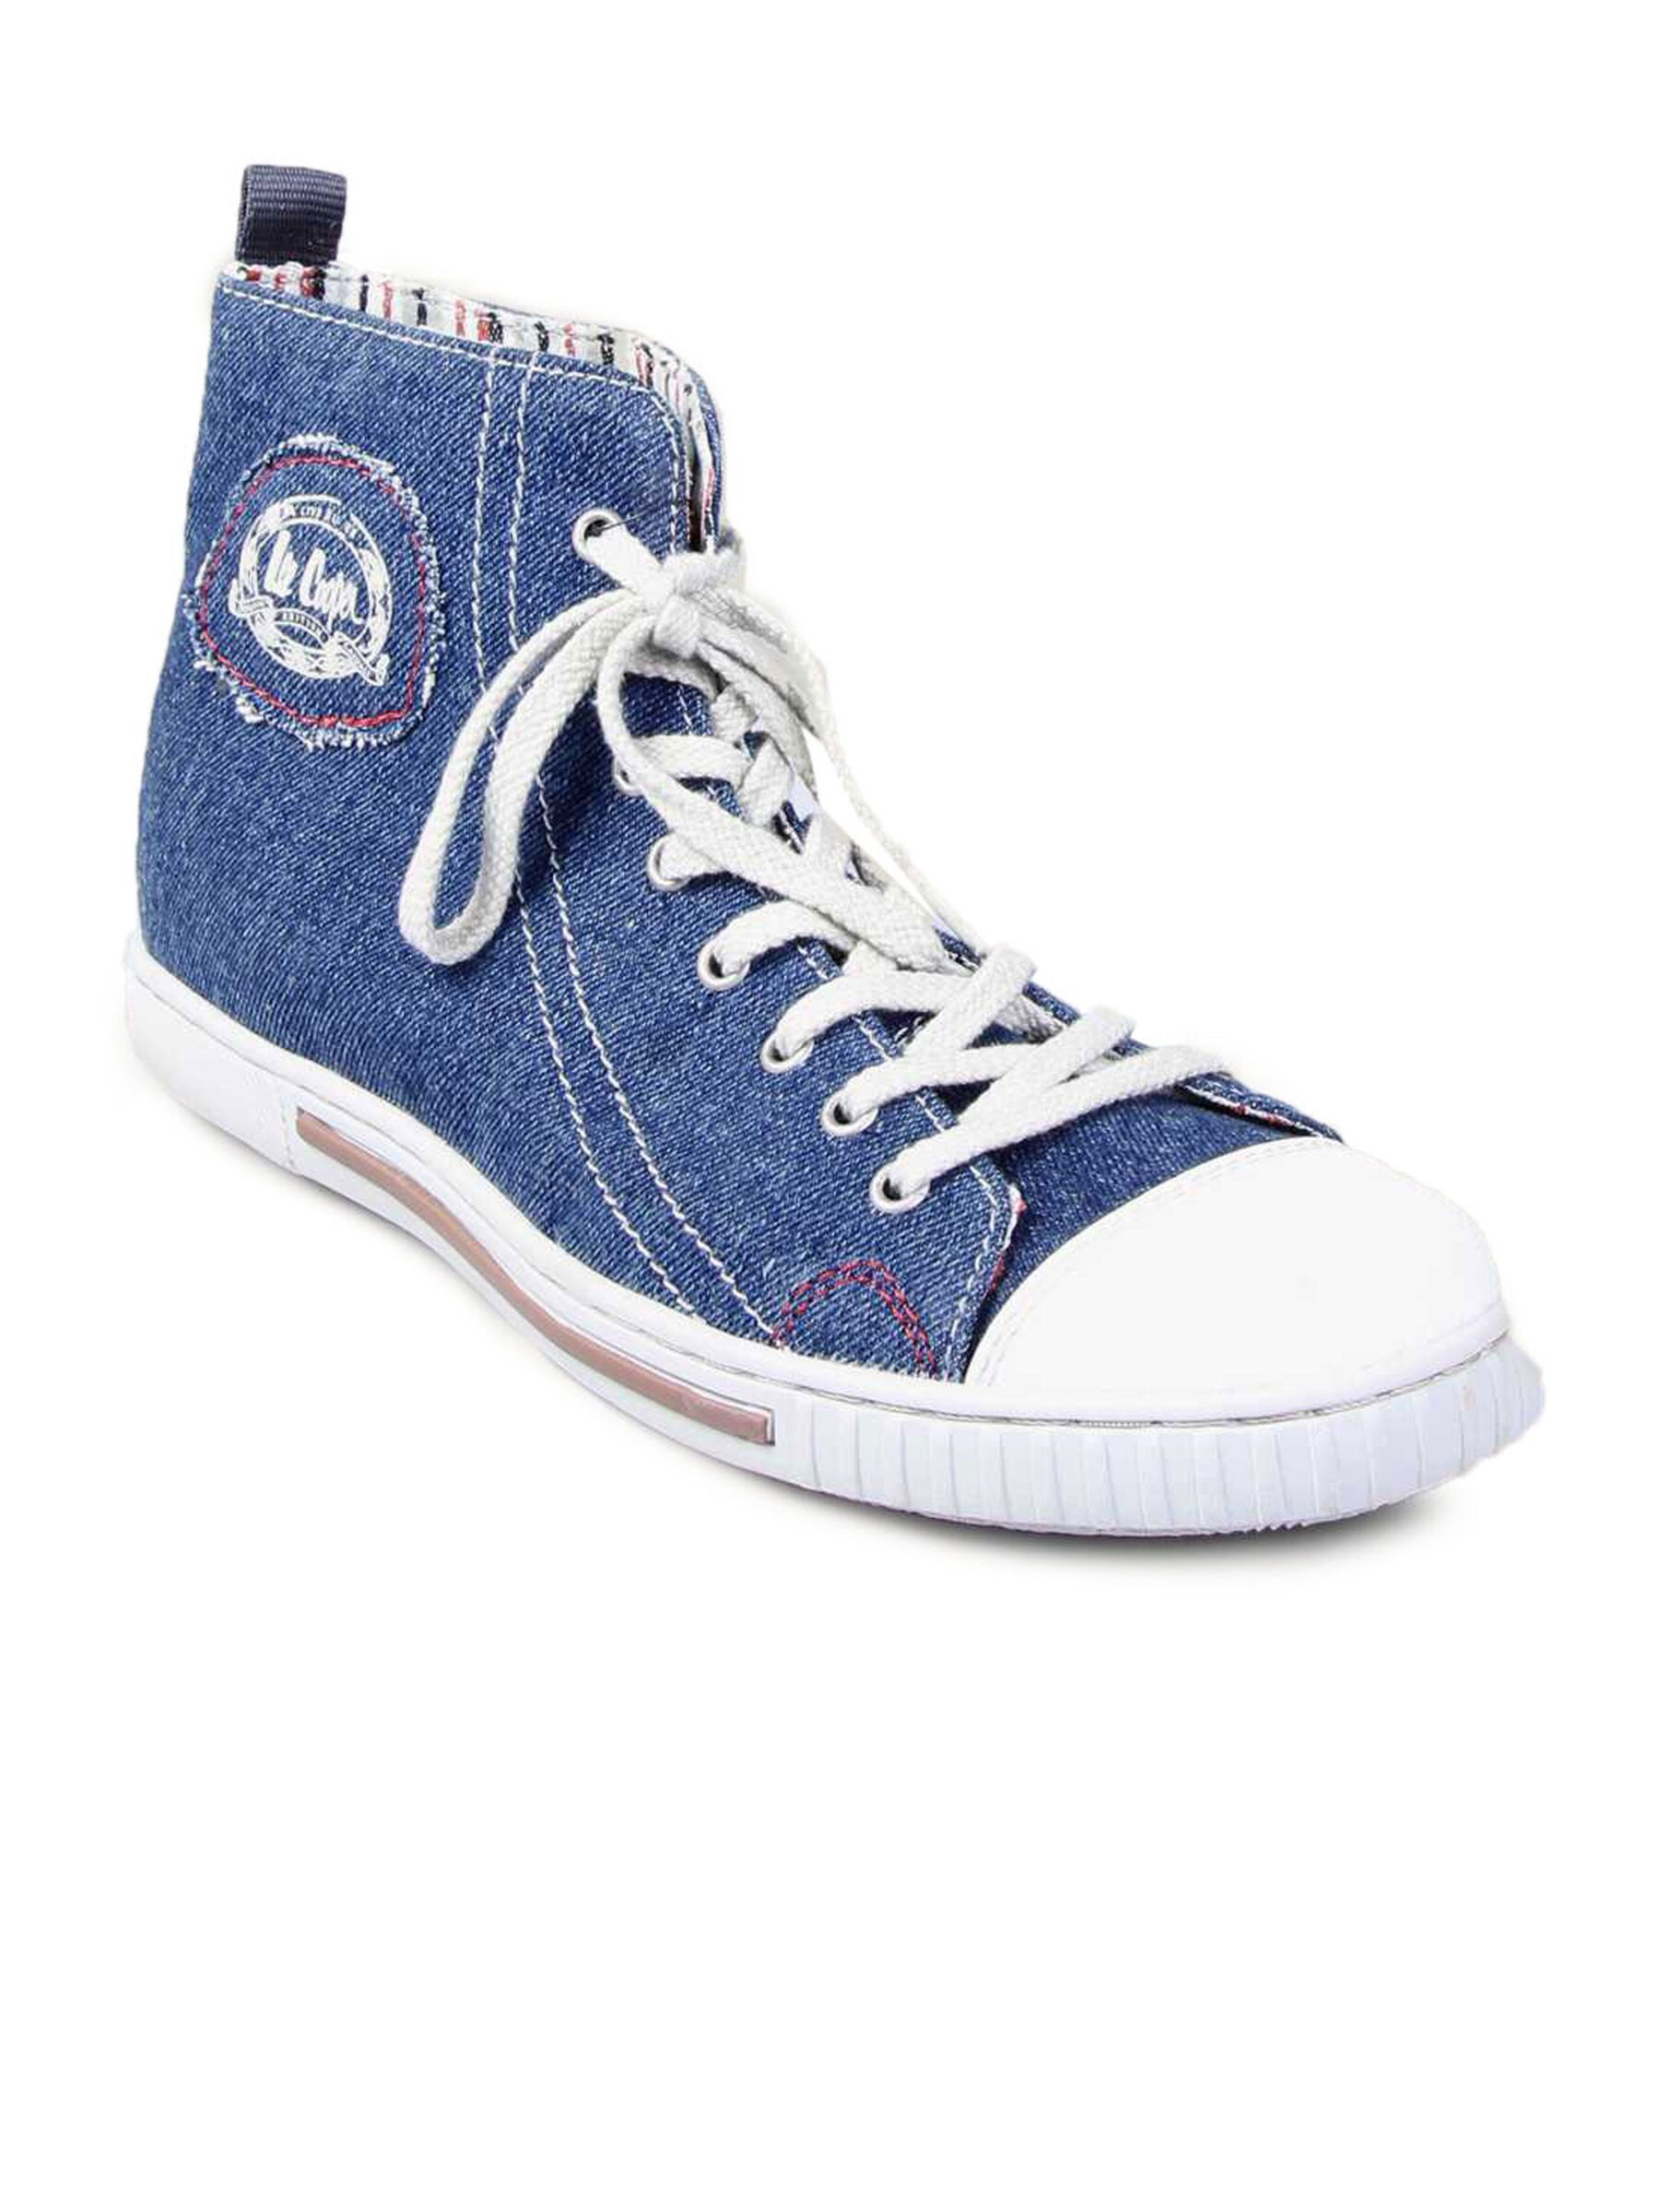

In [29]:
Image('2828.jpg')

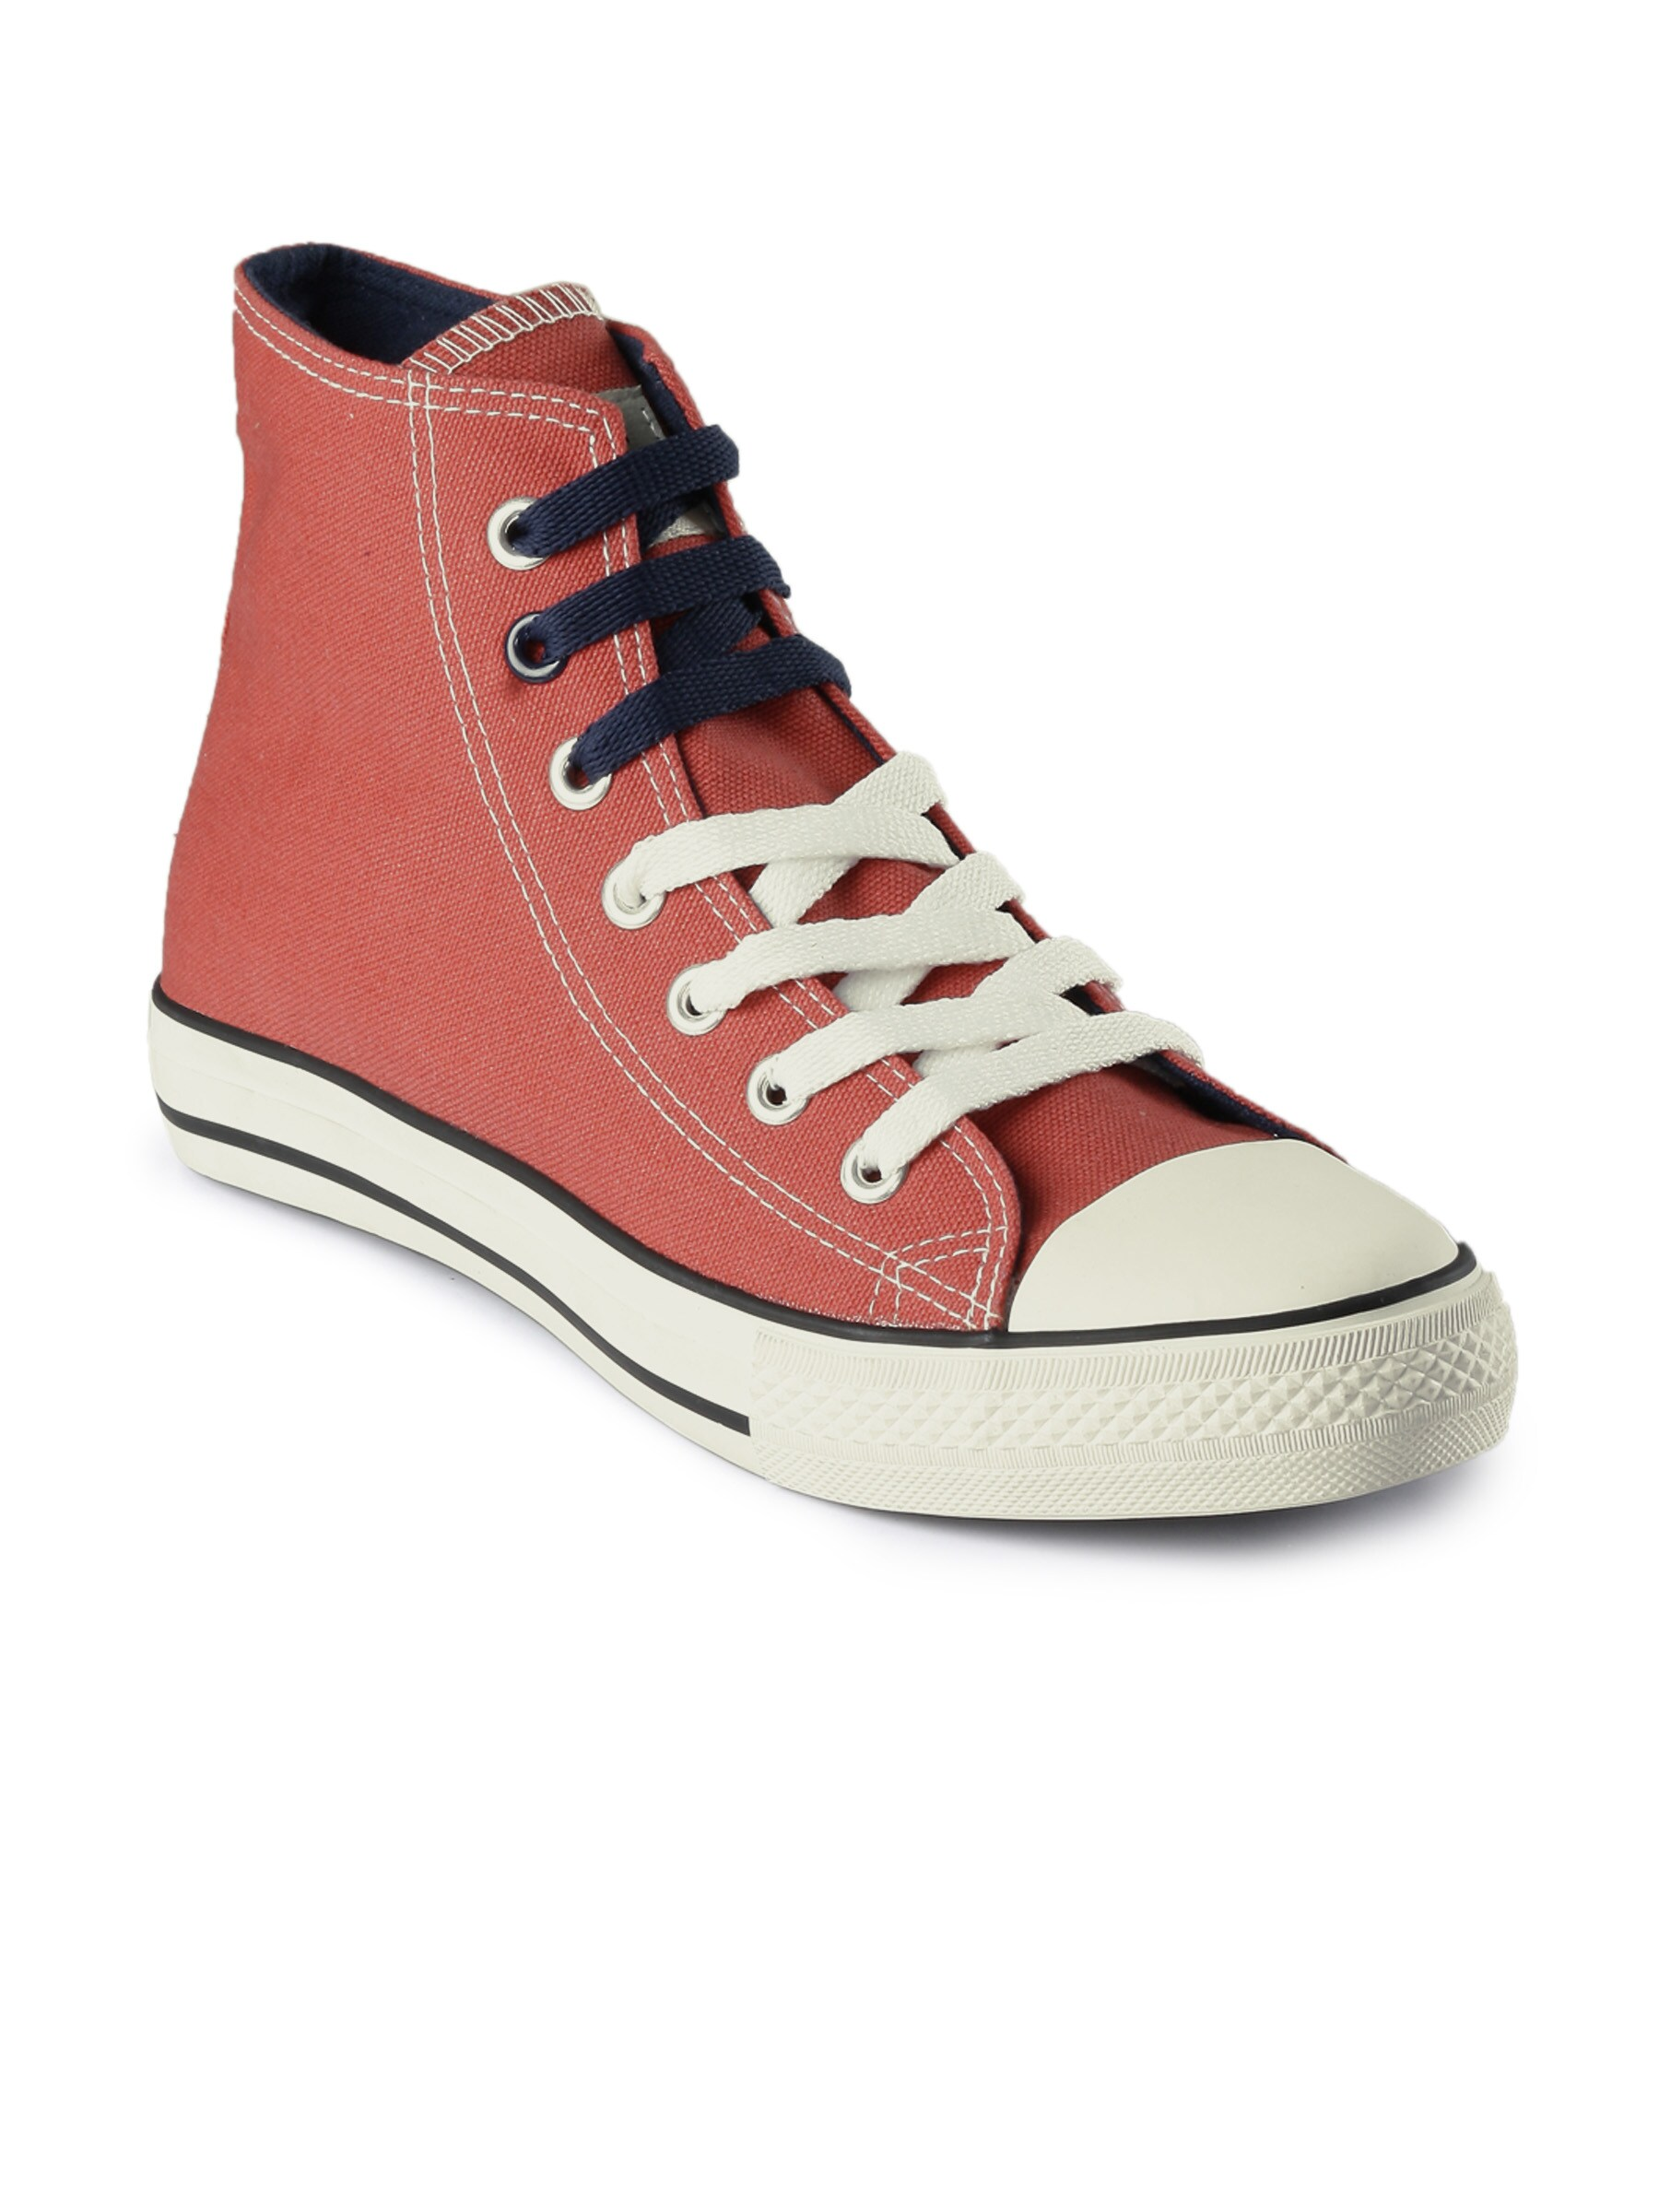

In [30]:
Image(filenames[indices[0][1]])

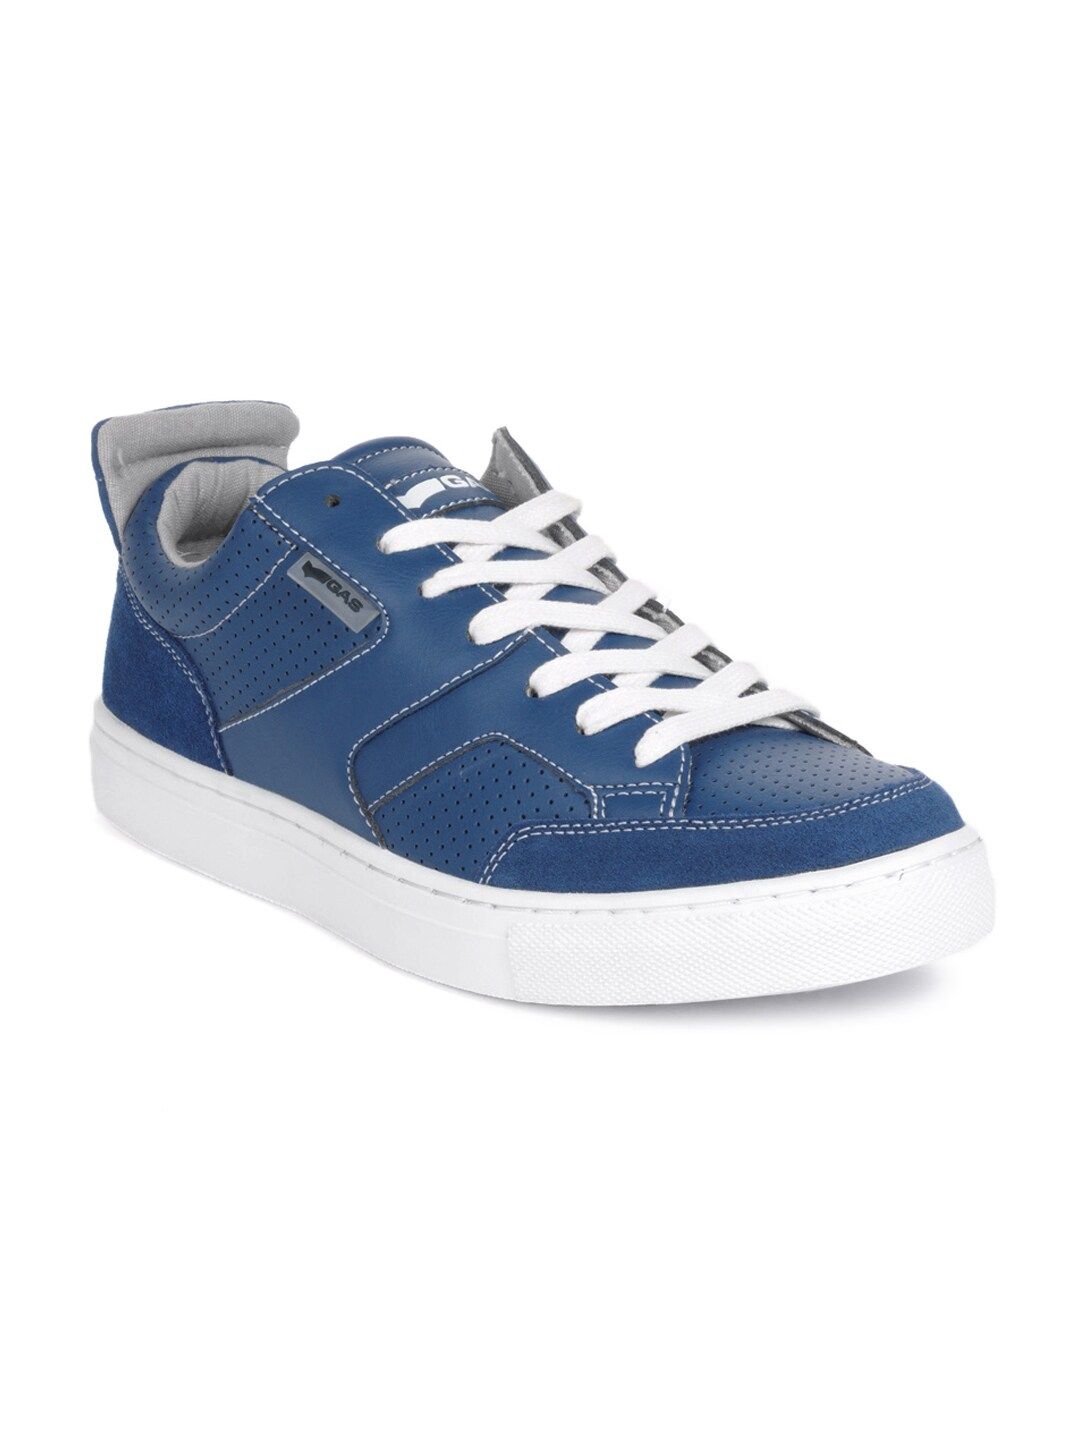

In [31]:
Image(filenames[indices[0][2]])

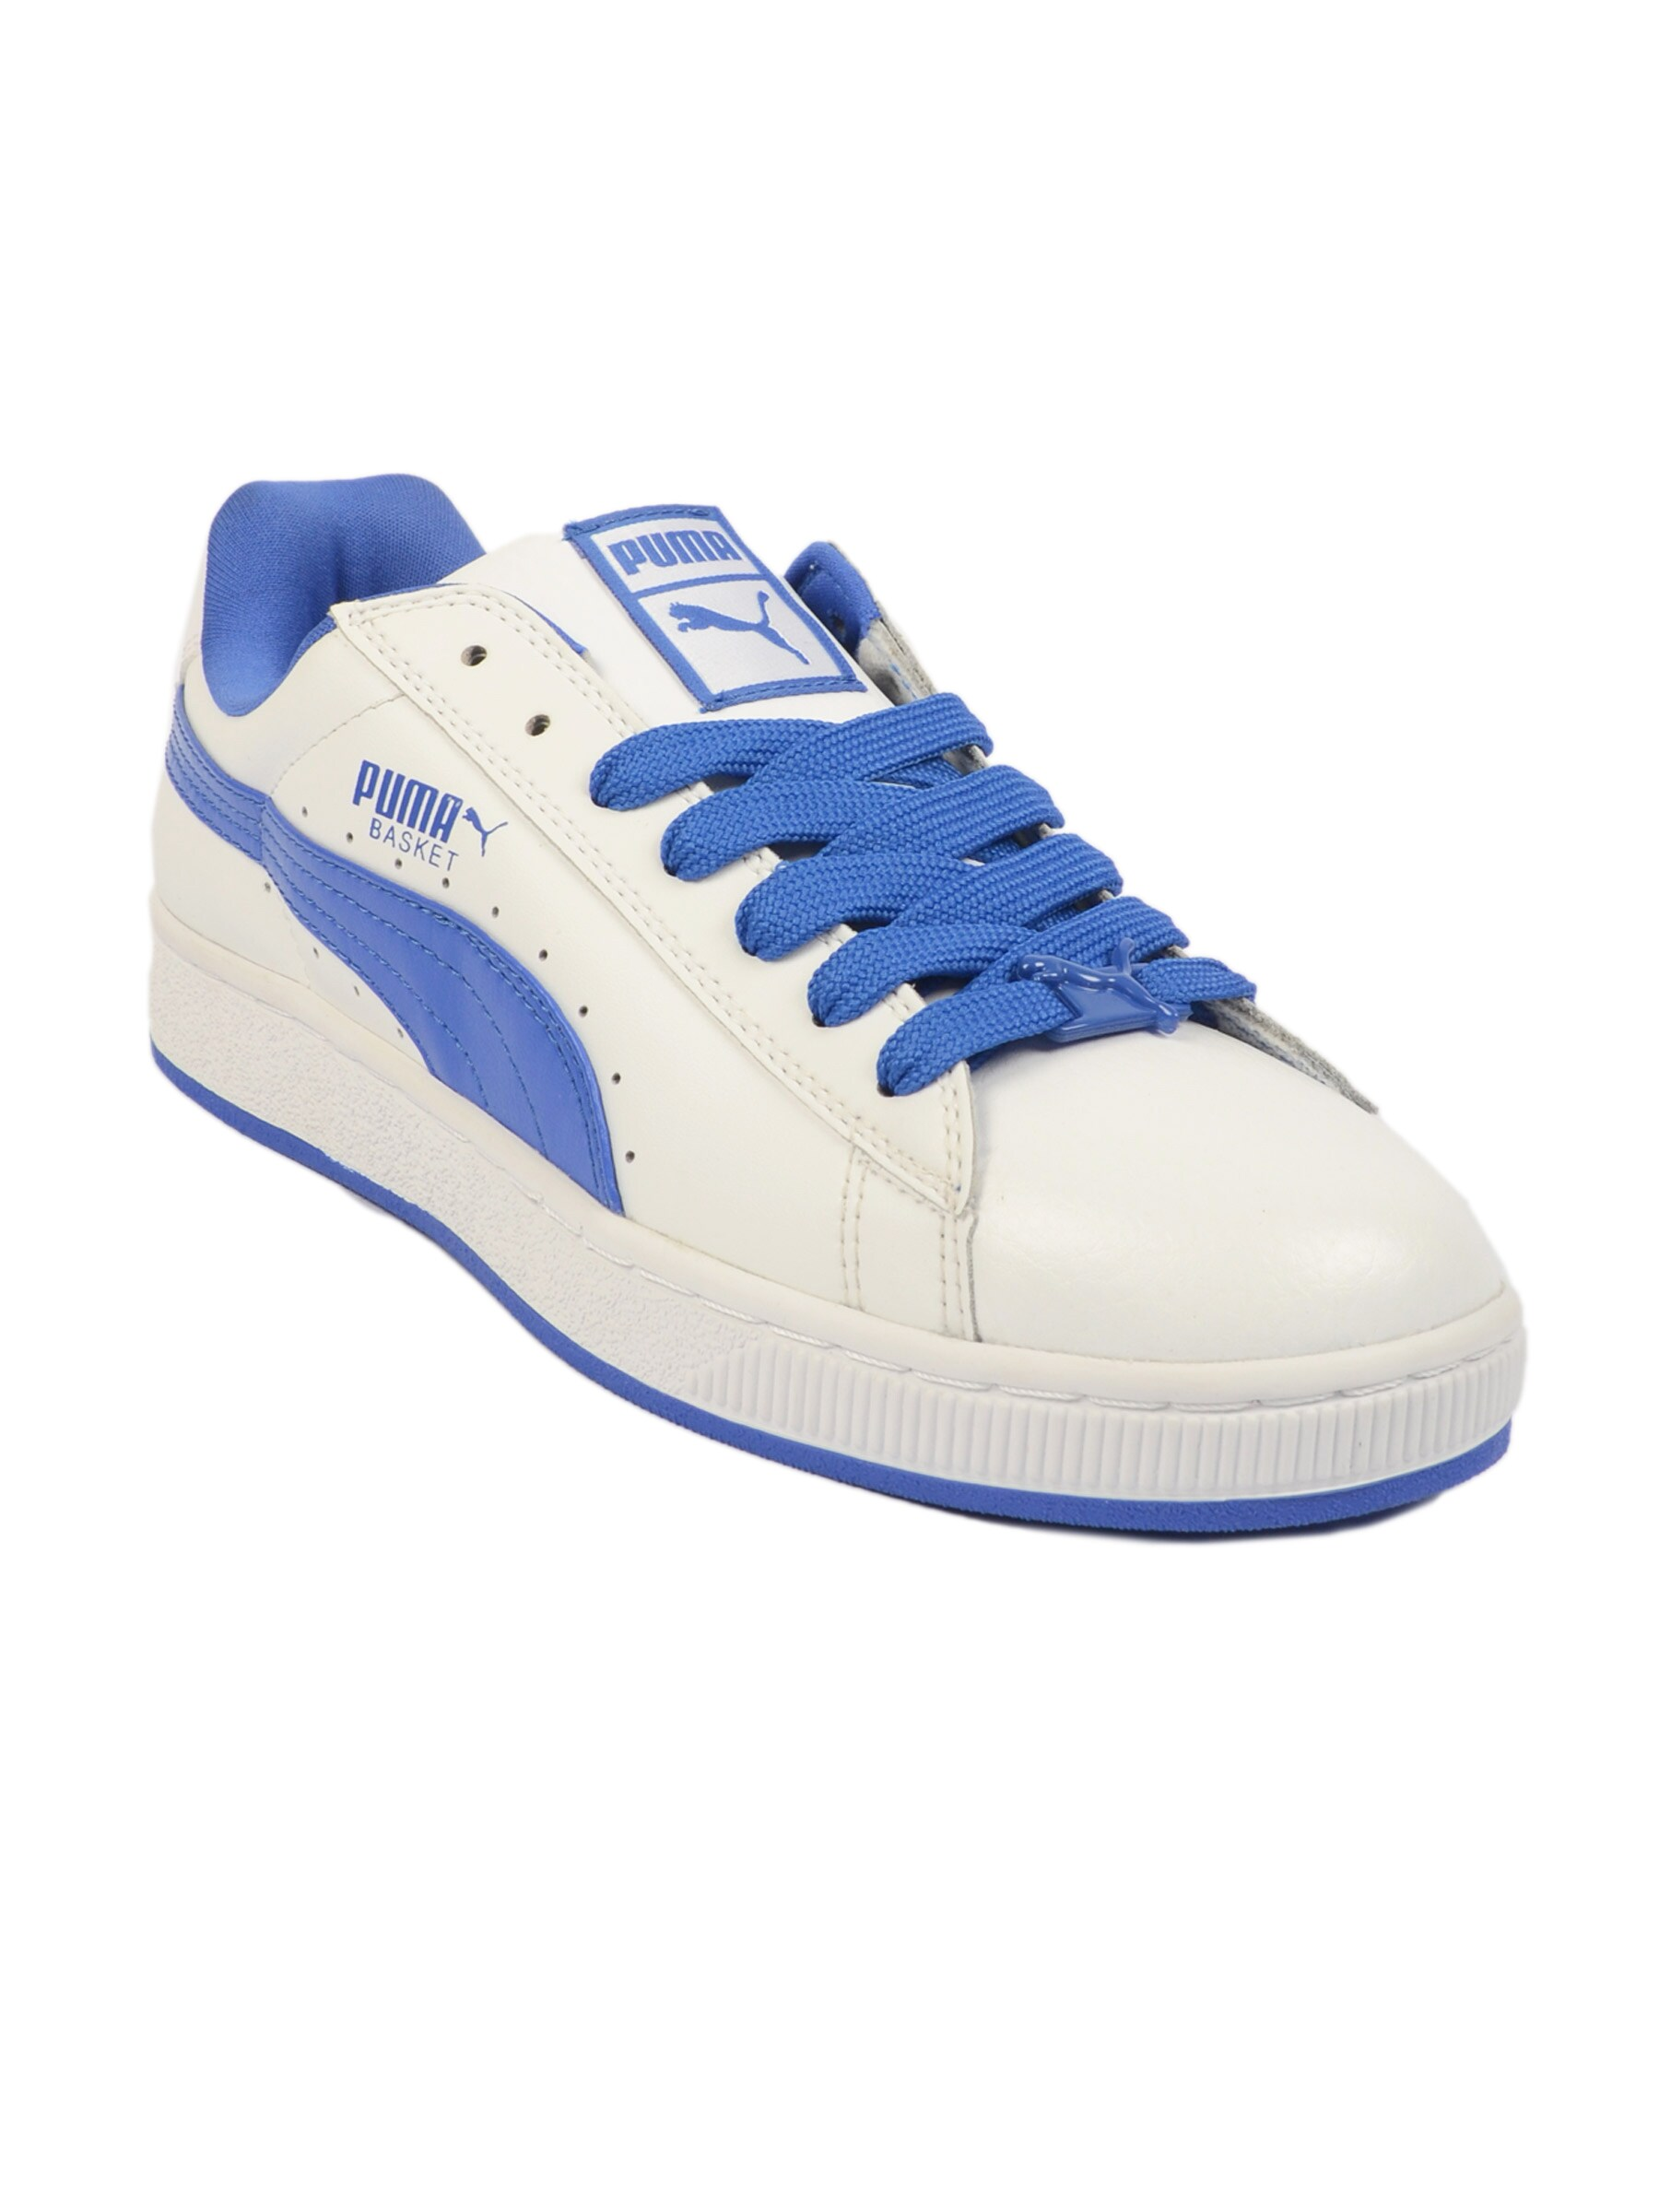

In [32]:
Image(filenames[indices[0][3]])

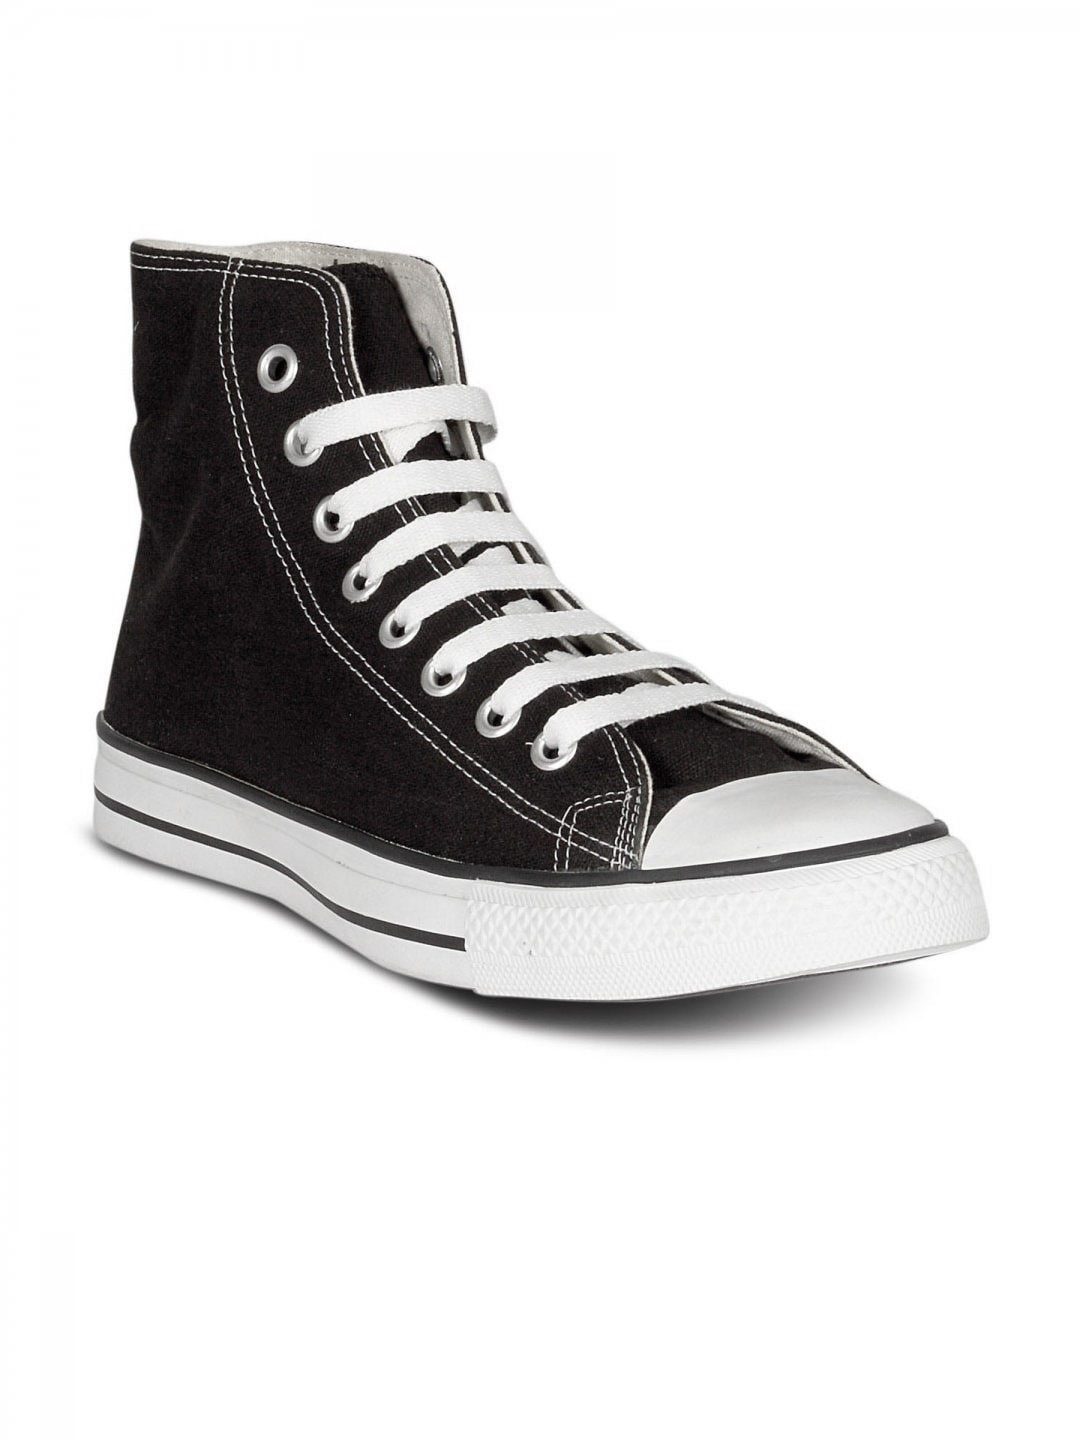

In [33]:
Image(filenames[indices[0][4]])

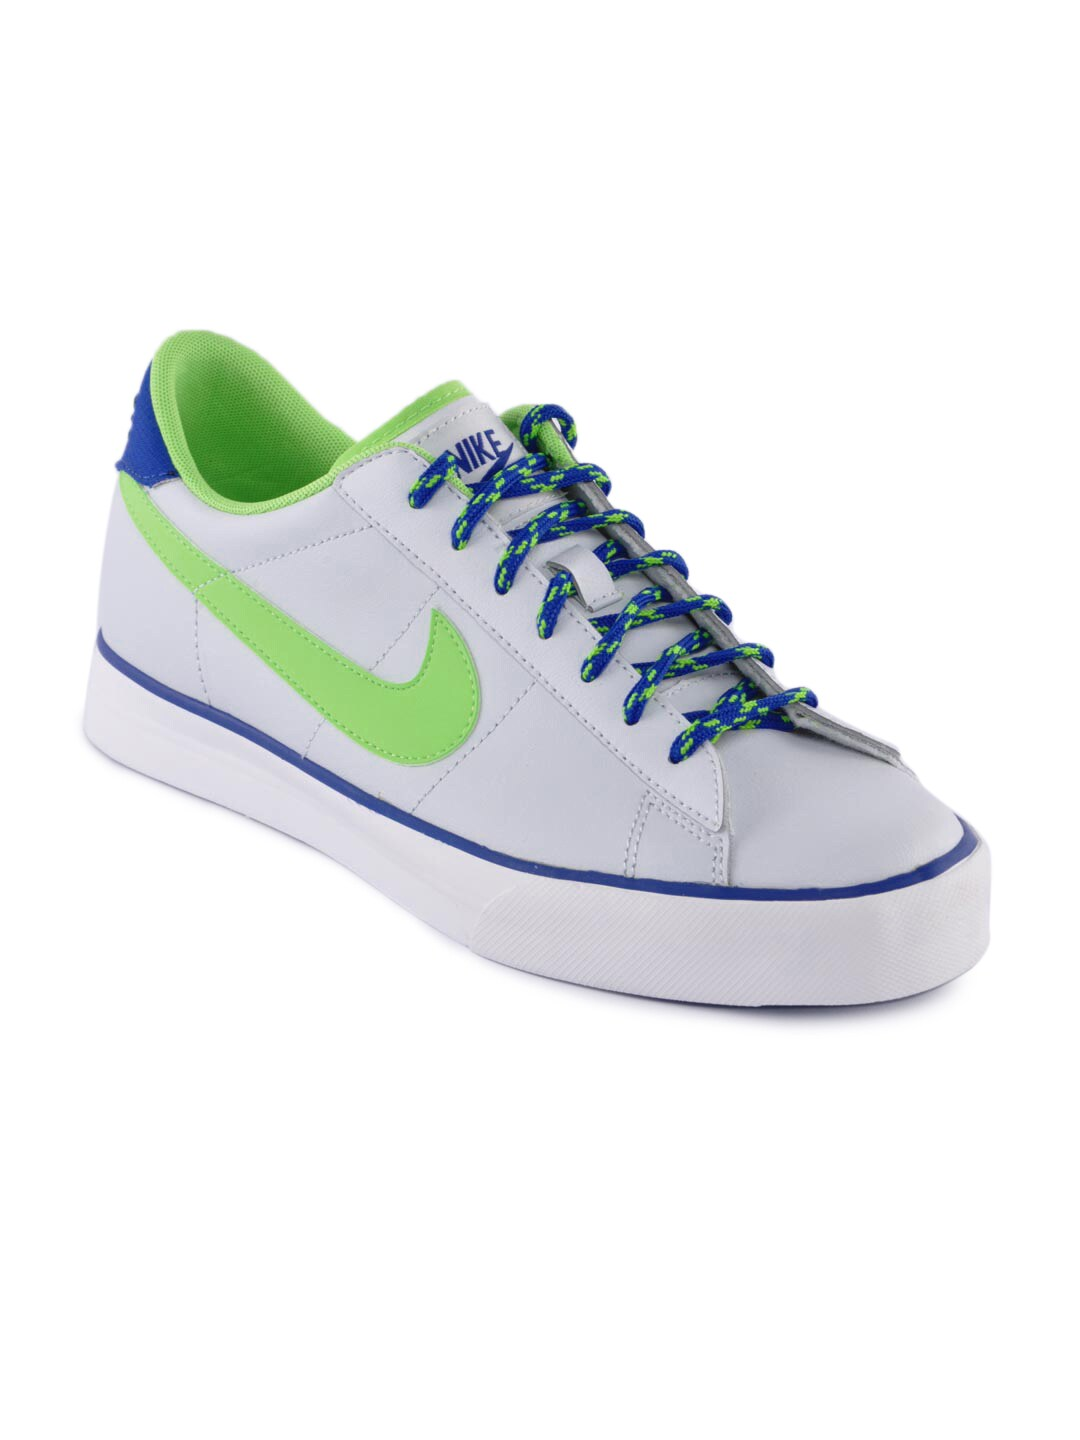

In [34]:
Image(filenames[indices[0][5]])